<a href="https://colab.research.google.com/github/chettkulkarni/MusicTutor_Model_Building/blob/main/Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Appreciating Indian Music using AI*

---


##### Chetan | Nupur | Lokesh
##### **Advisor : Vishnu Pendyala**



---


## Feature Extraction


---

Extracted features:


1.   **Chromagram**

  The term chroma feature or chromagram closely relates to the twelve different pitch classes. Chroma-based features are a powerful tool for analyzing music whose pitches can be meaningfully categorized.
  
2.   **Spectrogram**

  A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time. When applied to an audio signal, spectrograms are sometimes called sonographs, voiceprints, or voicegrams.

3. **Mel Frequency Cepstrum**

  The MFCCs are a very powerful representation of an audio signal as it scales the frequency in order to match more closely what the human ear can hear.




# Importing Required Libraries

In [ ]:
# feature extractoring and preprocessing data
!apt install ffmpeg
!sudo apt-get install libav-tools
!sudo apt-get install ffmpeg 
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Keras
import keras

import warnings
warnings.filterwarnings('ignore')

import re
import numpy as np

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import seaborn as sns

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package libav-tools is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source
However the following packages replace it:
  ffmpeg

E: Package 'libav-tools' has no installation candidate
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 's

# Spectrogram Feature Extraction

In [ ]:
genres = raagList
for g in genres:
    pathlib.Path(f'/content/img_data/{g}').mkdir(parents=True, exist_ok=True) 
    for filename in os.listdir(f'/content/drive/MyDrive/SplitSongs/{g}'):
        print(g,filename)
        if filename=='.ipynb_checkpoints' or filename=='.DS_Store':
          continue
        songname = f'/content/drive/MyDrive/SplitSongs/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True)
        plt.figure(figsize=(15,5))
        spec=librosa.feature.melspectrogram(y=y,sr=sr)
        librosa.display.specshow(spec)
        
        path1='/content/img_data/'+g
        plt.savefig(path1+'/{}png'.format(filename[:-3]))
        plt.clf()

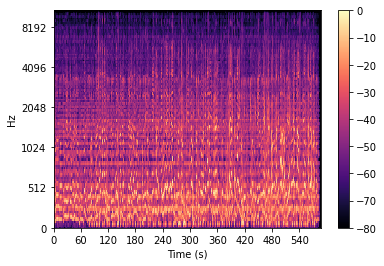

In [ ]:
y, sr = librosa.load(SAMPLEDATA_PATH, mono=True)
spec = librosa.feature.melspectrogram(y=y, sr=sr)
db_spec = librosa.power_to_db(spec, ref=np.max,)
librosa.display.specshow(db_spec,y_axis='mel', x_axis='s', sr=sr)
plt.colorbar();

The mel spectrogram displays pitch in a more regularized distribution.

# Chromagram Feature Extraction

Now that the percussive features are separated out we can extract which pitches are present as notes from the harmonic features.

In [ ]:
genres = raagList
for g in genres:
    pathlib.Path(f'/content/img_data/{g}').mkdir(parents=True, exist_ok=True) 
    for filename in os.listdir(f'/content/drive/MyDrive/SplitSongs/{g}'):
        print(g,filename)
        if filename=='.ipynb_checkpoints' or filename=='.DS_Store':
          continue
        songname = f'/content/drive/MyDrive/SplitSongs/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True)
        plt.figure(figsize=(15,5))
        chromagra=librosa.feature.chroma_stft(y=y,sr=sr)
        librosa.display.specshow(chromagra)
        path1='/content/img_data/'+g
        plt.savefig(path1+'/{}png'.format(filename[:-3]))
        plt.clf()

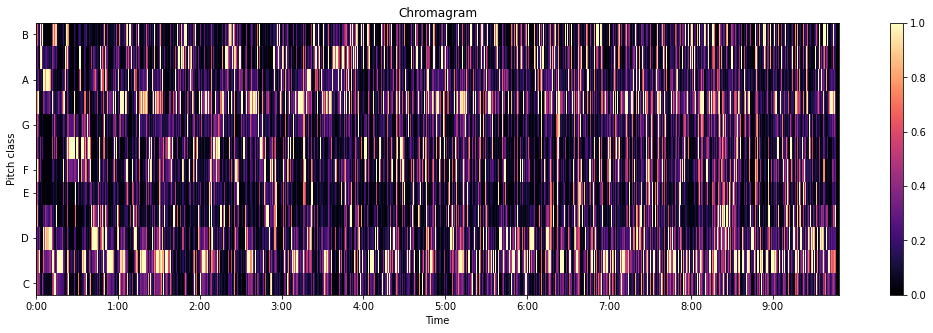

In [ ]:
SAMPLEDATA_PATH = "/content/Ajoy Chakrabarty - Aahir Bhairon.mp3"
y, sr = librosa.load(SAMPLEDATA_PATH, mono=True)
chroma=librosa.feature.chroma_stft(y=y,sr=sr)
plt.figure(figsize=(18,5))
librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)
plt.title('Chromagram')
plt.colorbar()

Above shows which pitches are present as notes from the extracted harmonic features.

# MFCC Feature Extraction
Each song is split into 10 segments. The snapshot of that segment is taken and MFCC is created.

In [ ]:
import json
import os
import math
import librosa

DATASET_PATH = "/content/processed/RagaDatasetNew"
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.

        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": [],
        "Xdb" : []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
    
      # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        
        try:
          # ensure we're processing a genre sub-folder level
          if dirpath is not dataset_path:

              # save genre label (i.e., sub-folder name) in the mapping
              semantic_label = dirpath.split("/")[-1]
              data["mapping"].append(semantic_label)
              print("\nProcessing: {}".format(semantic_label))

              # process all audio files in genre sub-dir
              for f in filenames:
                  

      # load audio file
                  file_path = os.path.join(dirpath, f)
                  signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                  # process all segments of audio file
                  for d in range(num_segments):

                      # calculate start and finish sample for current segment
                      start = samples_per_segment * d
                      finish = start + samples_per_segment

                      # extract mfcc
                      mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                      mfcc = mfcc.T

                      X = librosa.stft(signal[start:finish])
                      Xdb = librosa.amplitude_to_db(abs(X))
                      Xdb = Xdb.T
                      print(Xdb)


                      spectral_centroid_var=librosa.feature.spectral_centroid(signal[start:finish], sr=sample_rate)[0]
                      spectral_centroid_var=spectral_centroid_var.T

                      # store only mfcc feature with expected number of vectors
                      if len(mfcc) == num_mfcc_vectors_per_segment:
                          data["mfcc"].append(mfcc.tolist())
                          data["Xdb"].append(Xdb.tolist())
                          data["spectral_centroid_var"].append(spectral_centroid_var.tolist())
                          data["labels"].append(i-1)

                          print("{}, segment:{}".format(file_path, d+1))
                      
                          
        except:
          continue

      # save MFCCs to json file
    with open(json_path, "w") as fp:
          json.dump(data, fp, indent=4)
        
        

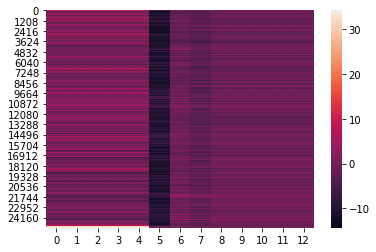

In [ ]:
y, sr = librosa.load(SAMPLEDATA_PATH)
mfcc = librosa.feature.mfcc(y=y, sr=22050, hop_length=512, n_mfcc=13)
mfcc=mfcc.T
mfcc_delta = librosa.feature.delta(mfcc)
sns.heatmap(mfcc_delta)

Above image shows the MFCC of an audio signal which describes the overall shape of the spectral envelope.